# Model Validation and Data Untiler
### Tom Ginsberg

First we define several predictors

In [3]:
from segment_trees import PREDICTORS, get_predictor
from deepent.data.untiler import new_polygon_q, format_predictions, PolygonRecord, affine_polygon
from tools.predictor import RGBDPredictor
from shapely.errors import TopologicalError
from shapely.geometry import Polygon
from detectron2.engine import DefaultPredictor

DEVICE = 'cpu'

In [4]:
import os
os.chdir('/home/ubuntu/drone-tree-id')

In [5]:
sequoia = get_predictor(**PREDICTORS['sequoia'], confidence=.5)
sequoialowconf = get_predictor(**PREDICTORS['sequoia'], confidence=.1)
sequoiamediumlowconf = get_predictor(**PREDICTORS['sequoia'], confidence=.3)

In [6]:
fuse60 = get_predictor(**PREDICTORS['fuse60'], confidence=.5)
fuse60lowconf = get_predictor(**PREDICTORS['fuse60'], confidence=.1)
fuse60mediumlowconf = get_predictor(**PREDICTORS['fuse60'], confidence=.3)

In [7]:
fuse30 = get_predictor(**PREDICTORS['fuse30'], confidence=.5)
fuse30lowconf = get_predictor(**PREDICTORS['fuse30'], confidence=.1)
fuse30mediumlowconf = get_predictor(**PREDICTORS['fuse30'], confidence=.3)

In [8]:
fuse90 = get_predictor(**PREDICTORS['fuse30'], confidence=.5)
fuse90lowconf = get_predictor(**PREDICTORS['fuse30'], confidence=.1)
fuse90mediumlowconf = get_predictor(**PREDICTORS['fuse30'], confidence=.3)

In [9]:
info = {'config_file': 'configs/deepent_rcnn_R_50_FPN.yaml',
                          'model': 'output/baseline_25_01_2020/model_0029999.pth', 'predictor': DefaultPredictor}
sequoiaearly = get_predictor(**info, confidence=.5)

In [10]:
import cv2
rgbd_read = lambda x: cv2.imread(x, cv2.IMREAD_UNCHANGED) 

In [11]:
from glob import glob
from random import choice
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from math import ceil

Now we load a tile

tile_1050.png


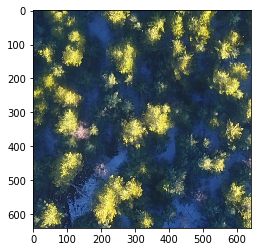

In [49]:
tile = choice(glob('../datasets/tmp/tiles/CPT2a-n/*.png'))
print(os.path.basename(tile))
img = cv2.imread(tile)
rgbd = rgbd_read(tile)
plt.imshow(img)

In [123]:
rgbd.shape

(640, 640, 4)

In [38]:
def plot_segs(t, models):
    h, w = ceil(len(models)/3), 3 if len(models)>=3 else len(models)
    fig, axes = plt.subplots(h, w, figsize=(10*w, 10* h))
    for model, ax in zip(models, axes.ravel()):
        polys = [poly for poly, _, _ in format_predictions(model(t)['instances'].to('cpu'), *t.shape[:-1])]
        for p in polys:
            ax.plot(*p.transpose())
        ax.imshow(t[:,:,0:3])

Checking out some predictions of the later fuse models the results are not great

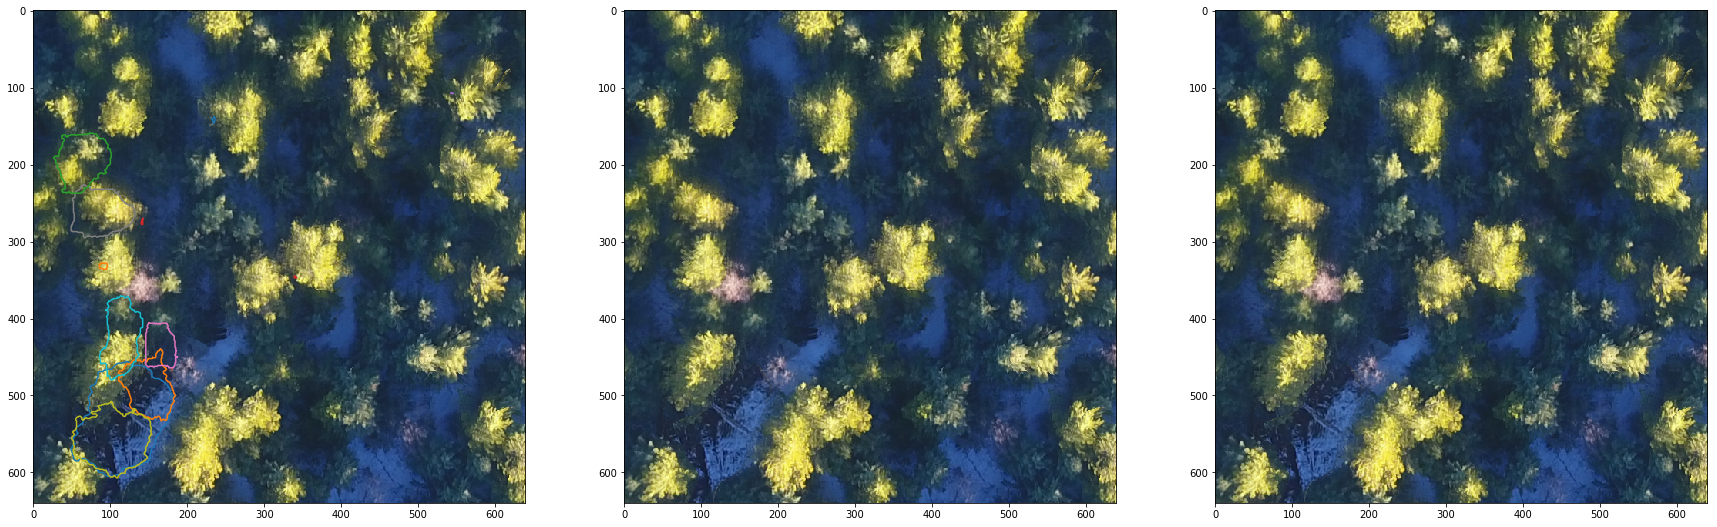

In [50]:
plot_segs(rgbd, [fuse90lowconf,fuse90mediumlowconf, fuse90])

The RGB baseline does quite well

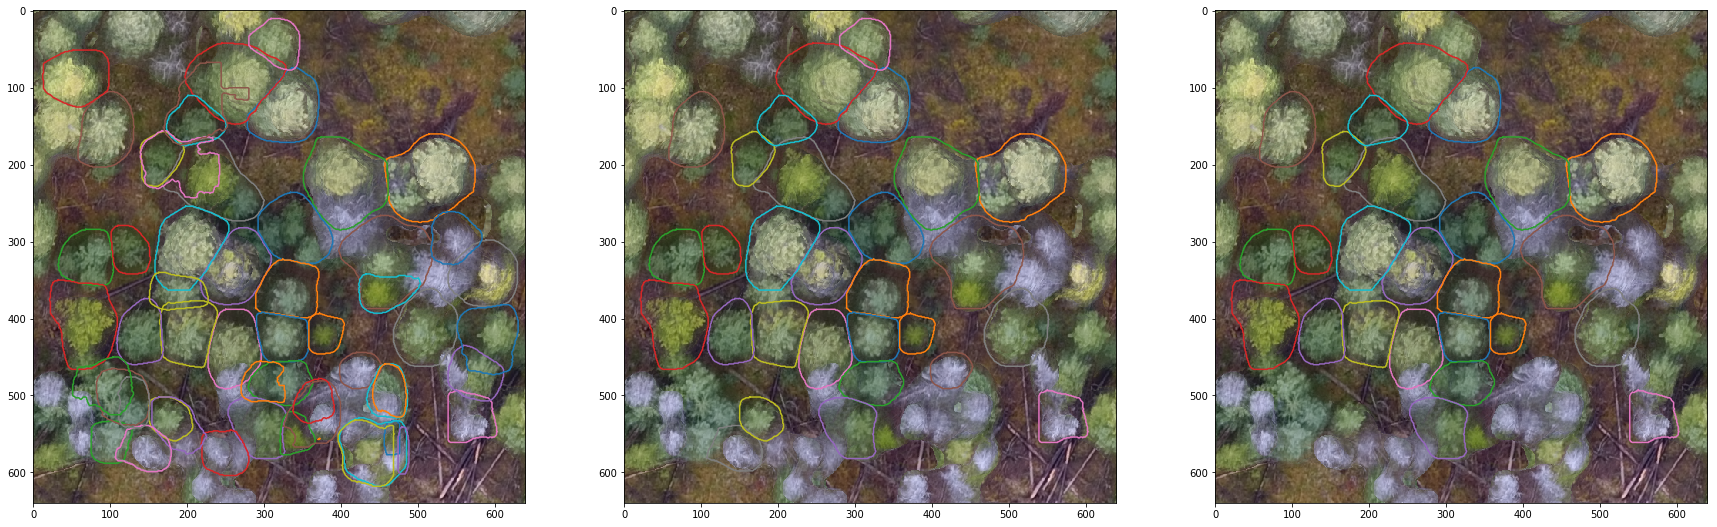

In [120]:
plot_segs(img, [sequoialowconf, sequoiamediumlowconf, sequoia])

The fuse model again does poorly

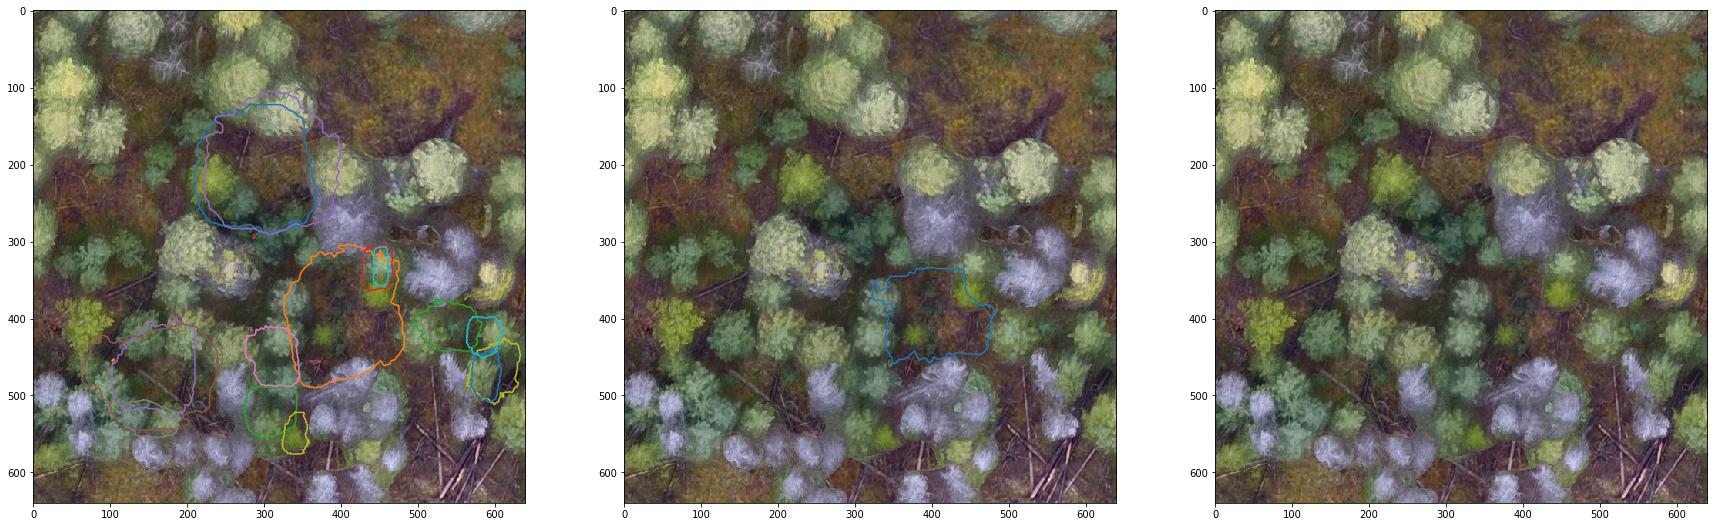

In [140]:
plot_segs(rgbd, [fuse60lowconf, fuse60mediumlowconf, fuse60])

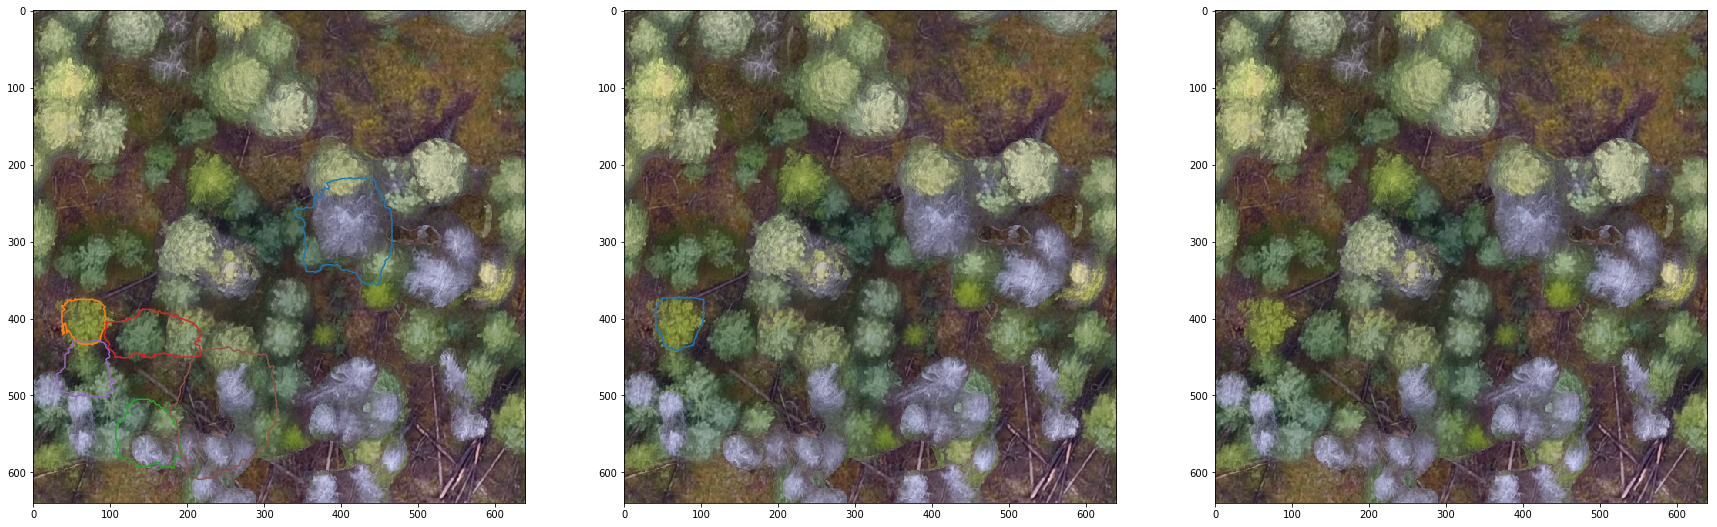

In [149]:
plot_segs(rgbd, [fuse30lowconf, fuse30mediumlowconf, fuse30])

The RBG model does better at later stages

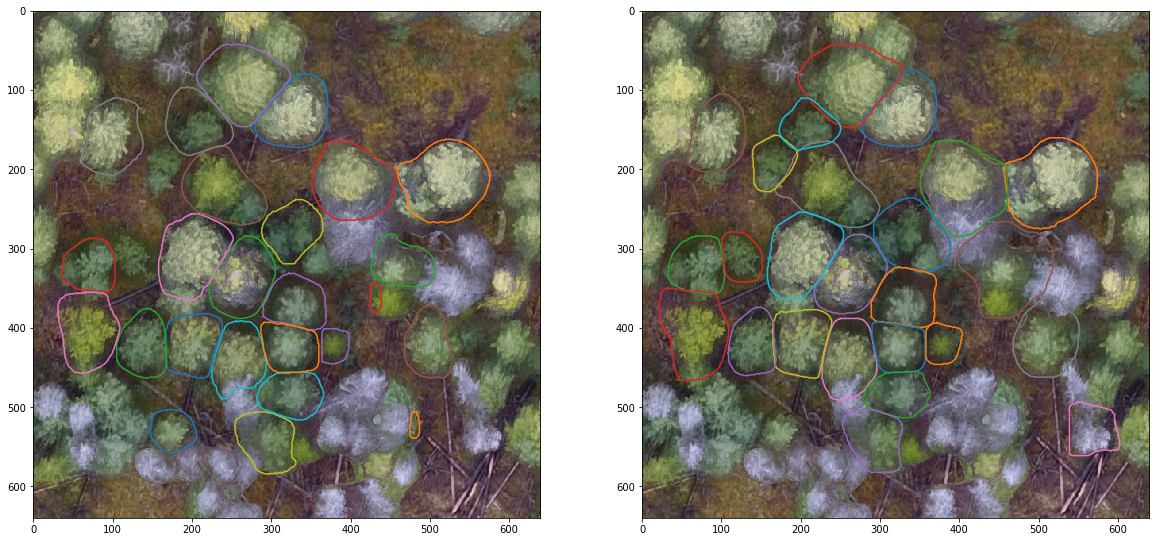

In [151]:
plot_segs(img, [sequoiaearly, sequoia])

### Now we check out rescaling tilewise predicitions back onto a full plot
We validate the rescaling as well as removal of duplicates

In [14]:
import json

def new_polygon_q(poly, neighbours, iou_thresh: .75, area_thresh=4, containment_thresh=.9, plot_errors=False):
    if poly.area < area_thresh:
        print('Area')
        if plot_errors:
            plt.plot(*np.array(poly.exterior.coords).transpose(), label='self')
            plt.legend()
            plt.show()
        return False
    for neighbour in neighbours:
        try:
            intersection = neighbour.intersection(poly).area
            if intersection / neighbour.union(poly).area > iou_thresh:
                print('IOU')
                if plot_errors:
                    plt.plot(*np.array(poly.exterior.coords).transpose(), label='self')
                    plt.plot(*np.array(neighbour.exterior.coords).transpose(), label='other')
                    plt.legend()
                    plt.show()
                return False
            if intersection / neighbour.area > containment_thresh:
                print(f'IO other {intersection / neighbour.area}')
                if plot_errors:
                    plt.plot(*np.array(poly.exterior.coords).transpose(), label='self')
                    plt.plot(*np.array(neighbour.exterior.coords).transpose(), label='other')
                    plt.legend()
                    plt.show()
                return False
            if intersection / poly.area > containment_thresh:
                print(f'IO self {intersection / poly.area}')
                if plot_errors:
                    plt.plot(*np.array(poly.exterior.coords).transpose(), label='self')
                    plt.plot(*np.array(neighbour.exterior.coords).transpose(), label='other')
                    plt.legend()
                    plt.show()
                return False
        except TopologicalError:
            return False
    return True

class UntilerMod:
    def __init__(self, predictors):
        self.predictors = predictors

    def predict_and_untile(self, path_to_tiles: str, duplicate_tol=.75, min_area=2):
        tree_id = 0

        with open(os.path.join(path_to_tiles, 'offsets.json'), 'r') as f:
            offsets = json.loads(f.read())
        x_scale, y_scale = offsets['transform']

        tiles = sorted(glob(os.path.join(path_to_tiles, "*.png")),
                       key=lambda x: int(os.path.basename(x).split('_')[-1][:-4]))
        poly_record = PolygonRecord(num_tiles=len(tiles), x_tiles=offsets['x_tiles'])
        removed_polys, total_polys = 0, 0
        for i, predictor in enumerate(self.predictors):
            for tile_num, tile in tqdm(enumerate(tiles)):
                if isinstance(predictor, RGBDPredictor):
                    img = cv2.imread(tile, cv2.IMREAD_UNCHANGED)
                else:
                    img = cv2.imread(tile)
                width, height = img.shape[1], img.shape[0]
                x_shift, y_shift = offsets[os.path.realpath(tile)]
                predictions = predictor(img)
                predictions = predictions["instances"].to(DEVICE)

                if predictions.has("pred_masks"):
                    for (polygon, area, cls) in format_predictions(predictions, height, width):
                        total_polys += 1
                        if len(polygon) > 4:
                            next_poly = Polygon(affine_polygon(polygon, x_scale, y_scale, x_shift, y_shift)).simplify(
                                0.2)
                            if new_polygon_q(next_poly, poly_record.get_neighbours(tile_num, lookahead=(i > 0)),
                                             iou_thresh=duplicate_tol, area_thresh=min_area, plot_errors=True):
                                poly_record.put(tile_num, next_poly, tree_id,
                                                area * x_scale * y_scale, cls)
                                tree_id += 1
                            else:
                                removed_polys += 1
                                # return early to not clutter the output
                                if removed_polys==5:
                                    return
        print(f'{removed_polys}/{total_polys} polygons removed')
        return poly_record

1it [00:00,  4.38it/s]

Area


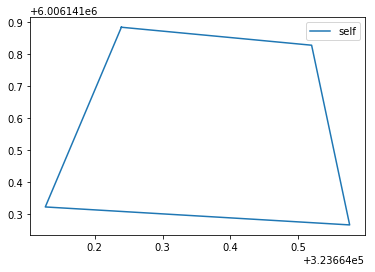

IOU


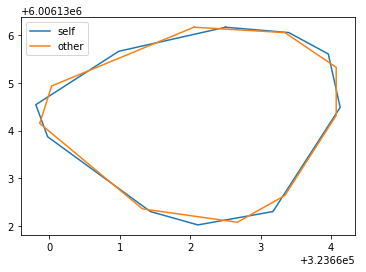

IOU


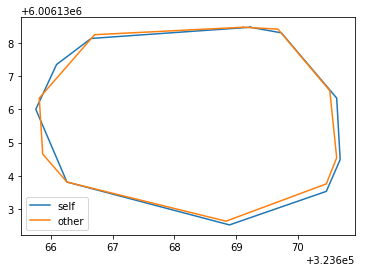

Area


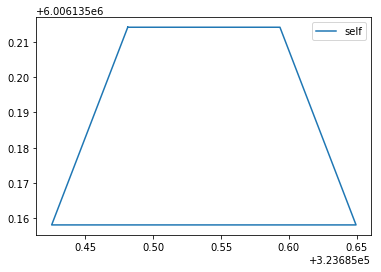

IOU


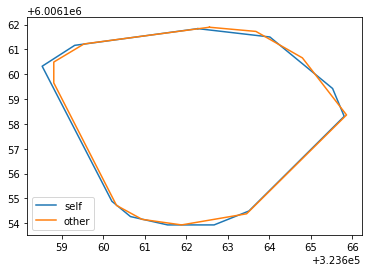

1it [00:00,  1.01it/s]


In [15]:
ut = UntilerMod([sequoia])
ut.predict_and_untile(glob('/home/ubuntu/tw*cl*/tmp/tiles/t*/')[0], duplicate_tol=.75)

The duplicat edetector seems to be working quite well. Below is the rescalled result which also seems quite good.

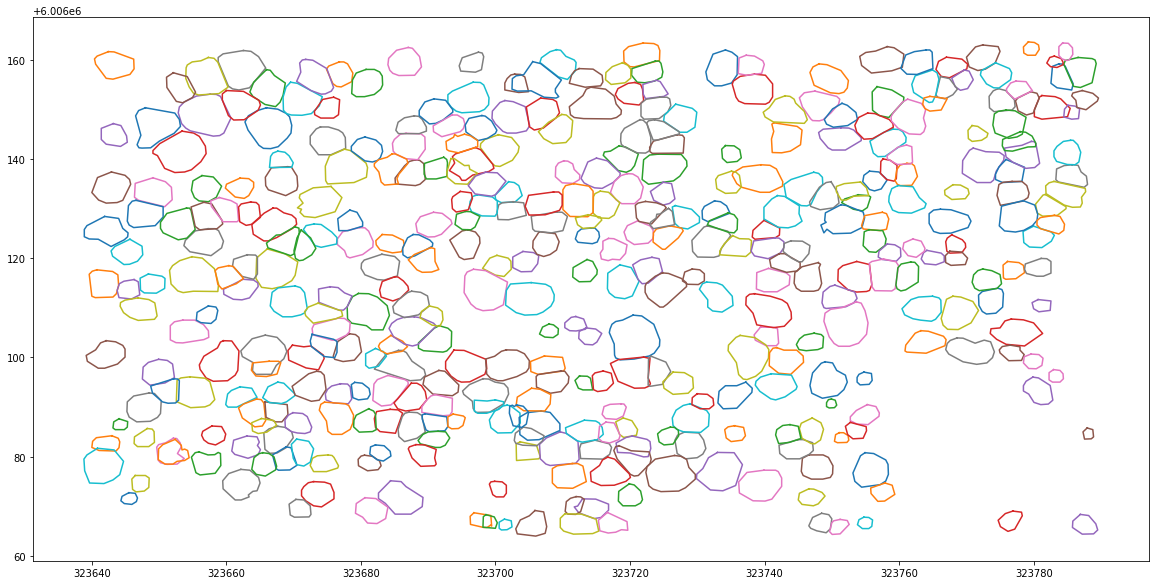

In [35]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
for t in prec2.polygons:
    for poly in t:
        ax.plot(*np.array(poly.exterior.coords).transpose())